### Презентация проекта по парсингу данных пользователей Вконтакте

### Город Волгоград

#### Задача: 
Запарсить данные через VK API, реализовать класс, протестировать его  и построить дешборд на освнове данных из VK API. 

#### Что сделано: 
1) Написан класс, который имеет следующий функционал: выгрузка данных о пользователе, а также выгрузка данных о пользователей из города N с датами рождения, возрастом и полом
2) Проведено тестирование на корректную работу функционала класса
3) Cоздан проект на Gitlab с веткой dev, test, master
4) Сделан дешборд в DataLens

#### Технологический стек:
Python(pytest, pandas, VK, json), VK API, Jupyter, Anaconda, Gitlab, DataLens

#### Вывод по полученным результатам: 
К сожалению, при парсинге данных у многих пользователей была введена некоректная дата рождения. Из-за этого пришлось сделать множество итераций через чикл, которые возвращали список пользователей согласно 2-ум вариантам сортировки и согласно возрастному диапозону.
Тем не менее, удалось загрузить более 500 пользователей каждого пола, однако, именна этих пользователей оказались странными, имели итальянский манер. 

#### Вывод по тестированию: 
Тестирование покрывает весь функционал класса, в ходе тестирования ошибок не возникло.

#### Ссылки:
Ссылка на дешборд: https://datalens.yandex/see4eo5pt0puh
Ссылка на ГИТ: https://gitlab.com/pony-group1/hw1_vk

### Релизация класса для парсинга данных

In [ ]:
import requests
import json
import pandas as pd
import vk
from datetime import datetime
import datetime as dt
import time
import warnings

warnings.filterwarnings("ignore")

In [2]:
class VK_connection: 
    """Class для парсинга данных из VK API""" 
 
    def __init__(self, access_token, api_v: str = '5.154') -> None: 
        self.access_token = access_token 
        self.api_v = api_v
        self.api = vk.API(access_token = self.access_token, v=self.api_v)
 
    """Парсер информации о своем профиле"""
    def get_one_user(self, user_id: int) -> dict: 
        
        return self.api.users.get(user_ids=user_id)
 
    """Парсер пользователей по городу и полу"""
    def get_users(self, city: int, sex: int ) -> pd.DataFrame: 
        
        
        users_list = []
        
        for first_date in range(5,95,10):
              for sort_id in range(0,2):
                    time.sleep(1) #чтобы не было блокировки на запросы
                    df = self.api.users.search(access_token=self.access_token, 
                                               sort=sort_id, count=1000, city=city, sex=sex, fields = ['bdate'], 
                                               age_from=first_date, age_to=first_date+10) 
                    df = pd.io.json.json_normalize(df['items'])

                    #удаляем ненужные колонки
                    df = df.drop('track_code', axis=1)
                    df = df.drop('can_access_closed', axis=1)
                    df = df.drop('is_closed', axis=1)

                    #создаем признак - пол
                    if sex == 2:
                        df['sex'] = 'Male'
                    if sex == 1:
                        df['sex'] = 'Female'

                    #преобразовываем дату рождения в возраст
                    now = dt.datetime.now()
                    df['bdate'] = df['bdate'].astype(str)
                    df = df[df['bdate'] != 'nan']
                    df = df[df['bdate'].str.match('^\d{2}.\d{2}.\d{4}$')]
                    df['bdate'] = df['bdate'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y'))
                    df['age'] = now.year - df['bdate'].dt.year
                    users_list.append(df)
        #соединяем выгрузки в 1 датафрейм
        df = pd.concat(users_list)
        #удаляем дубликаты
        df = df.drop_duplicates(subset=['id'], keep='first')
        #берем в случайном порядке 500 пользователей
        df = df.sample(n=500)
        return df

In [3]:
#берем токен
data_token = pd.read_csv('token.csv')
data_token = data_token.iloc[0]

In [4]:
#обращаемся к классу
con = VK_connection(data_token)

In [5]:
#выгружаем данные о себе для проверки работоспособности
con.get_one_user(539107399)

[{'id': 539107399,
  'first_name': 'Никита',
  'last_name': 'Марков',
  'can_access_closed': True,
  'is_closed': True}]

In [6]:
#указываем пол 1 если женский, 2 если мужской, а также id города
#ID Волгограда = 16
df_female = con.get_users(16, 1)
df_female

,id,bdate,first_name,last_name,sex,age
289,692285310,2003-12-15,Saodat,Erkinova,Female,20
52,742001212,1993-11-11,Maria,Antonia,Female,30
630,490552910,2000-10-30,Юдина,Людмила,Female,23
309,506368995,1968-11-22,Rita,Levi-Montalcini,Female,55
206,90882178,1966-11-14,Татьяна,Зотова,Female,57
...,...,...,...,...,...,...
193,633900262,1967-12-28,Daniela,Tamone,Female,56
67,137813163,1975-11-10,Татьяна,Мильченко,Female,48
390,188295370,1972-10-28,Bimbebelle,Bimbebelle,Female,51
180,660136733,1993-12-20,Fabrizio,Scemo,Female,30


In [7]:
df_male = con.get_users(16, 2)
df_male

,id,bdate,first_name,last_name,sex,age
690,633284938,1997-12-10,Lo,Ci,Male,26
264,621932622,1958-12-15,Mauro,Brossa,Male,65
31,807732798,1978-11-20,Lorenzo,Cherubini,Male,45
346,687555388,1990-10-15,Munda,Jutt,Male,33
1,758602047,1962-12-12,Giovanni,Broz,Male,61
...,...,...,...,...,...,...
256,550381160,1962-12-11,Carlo,Degliantoni,Male,61
7,258221272,1964-12-14,Prosto,Piano,Male,59
689,643161685,2002-12-29,Le,Cuccaro,Male,21
409,641527611,1987-11-13,Carmine,Lentini,Male,36


In [8]:
#итоговый датасет
total_df = pd.concat([df_male, df_female])
total_df

,id,bdate,first_name,last_name,sex,age
690,633284938,1997-12-10,Lo,Ci,Male,26
264,621932622,1958-12-15,Mauro,Brossa,Male,65
31,807732798,1978-11-20,Lorenzo,Cherubini,Male,45
346,687555388,1990-10-15,Munda,Jutt,Male,33
1,758602047,1962-12-12,Giovanni,Broz,Male,61
...,...,...,...,...,...,...
193,633900262,1967-12-28,Daniela,Tamone,Female,56
67,137813163,1975-11-10,Татьяна,Мильченко,Female,48
390,188295370,1972-10-28,Bimbebelle,Bimbebelle,Female,51
180,660136733,1993-12-20,Fabrizio,Scemo,Female,30


### Реализация тестирования

In [ ]:
import pytest
import pandas as pd
from VK_connection_class import VK_connection
# Подготовительные шаги для тестирования
data_token = pd.read_csv('token.csv')
data_token = data_token.iloc[0]

con = VK_connection(data_token)

@pytest.fixture
def con():
    return VK_connection(data_token)
#тест на выгрузку данных о пользователе
def user_info(con):
    data = con.get_one_user(539107399)
    assert len(data) == 0

    
#тест на выгрузку данных о пользователях женского пола
def test_query_api_female(con):
    df = con.get_users(16, 1)
    assert len(df) == 500
    
    
#тест на выгрузку данных о пользователях мужского пола
def test_query_api_male(con):
    df = con.get_users(16, 2)
    assert len(df) == 500


### Результаты тестирования

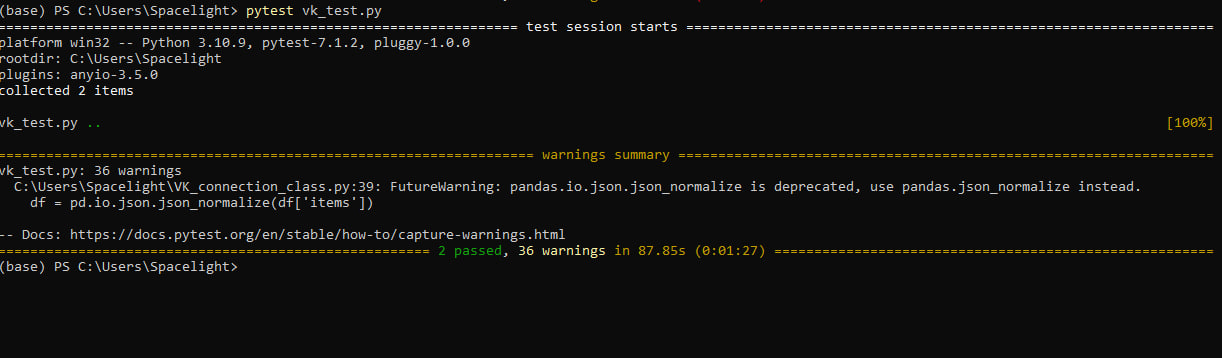

### Получившиеся дешборд

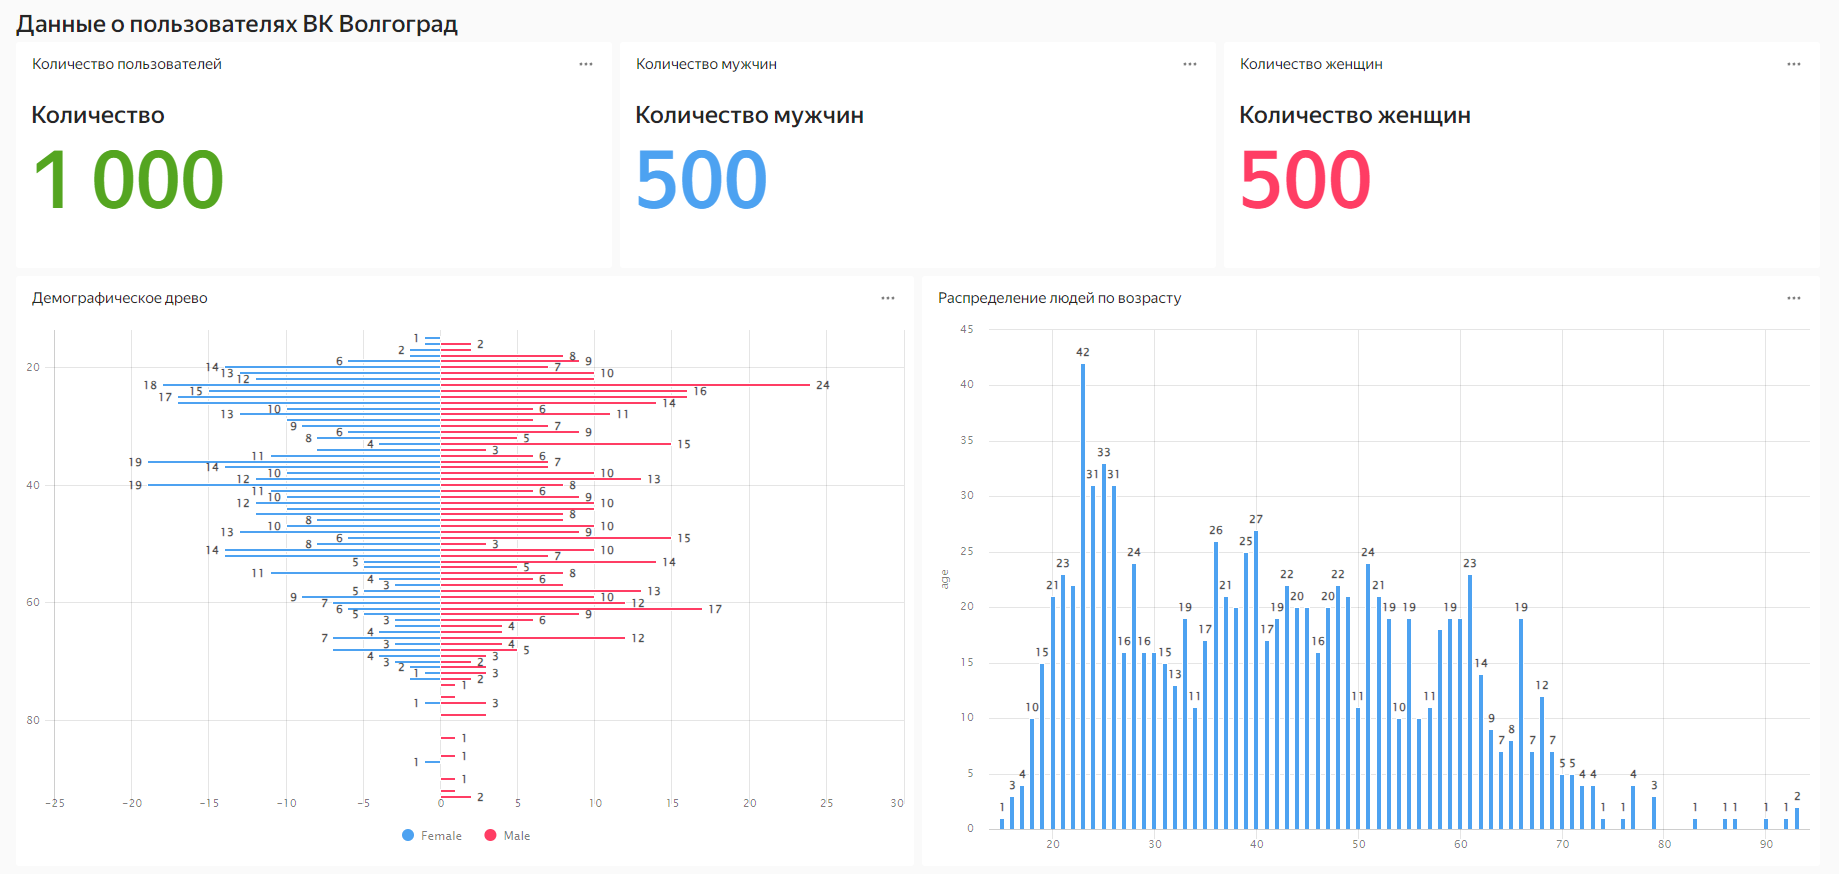

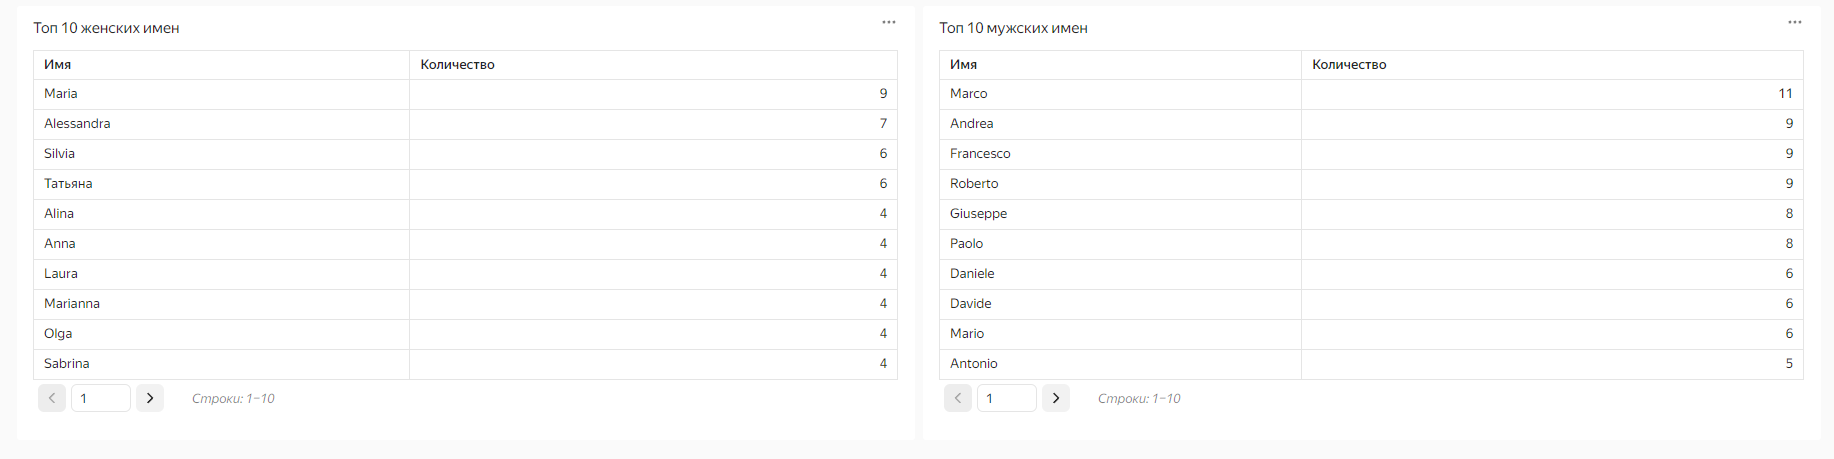


Ссылка на дешборд: https://datalens.yandex/see4eo5pt0puh

### Реализация ГИТ

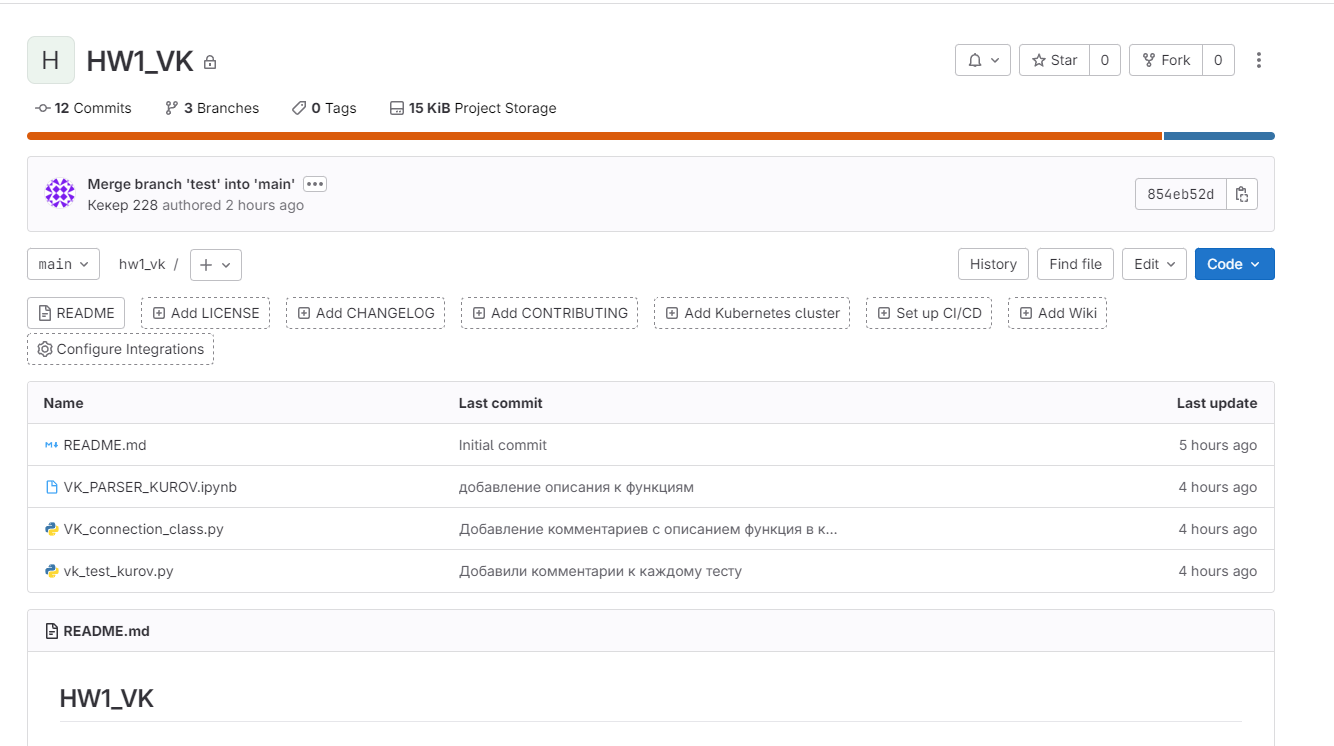

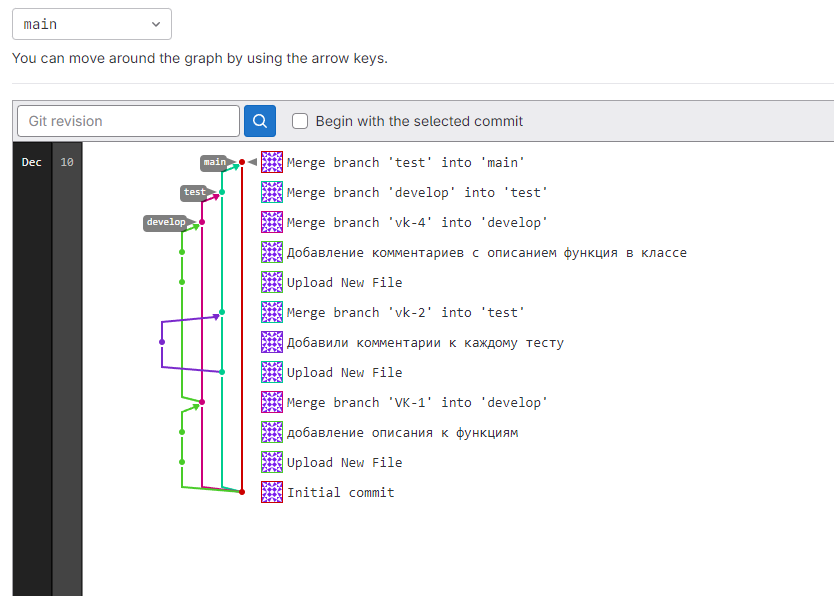

Ссылка на ГИТ: https://gitlab.com/pony-group1/hw1_vk